# Exercise 2. Backpropagation

### Learning goals

We will implement forward and backward computations in a simple neural network using pure numpy.
This will help the students understand:
* what is backpropagation
* how to implement and test gradient computations
* how backpropagation is implemented in packages like PyTorch

In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
# During grading, this cell sets skip_training to True
# skip_training = True

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

When implementing analytical computations of gradients, it is useful to test the implementation by computing gradients numerically and comparing the results. The function below computes the gradients numerically, you may (but do not have to) use this function to test your code.

In [4]:
# This function computes the gradient of a given function fun at input x numperically, using the specified
# perturbations eps
def numerical_gradient(fun, x, eps=1e-4):
    assert x.ndim <= 1, "Only vector inputs are supported"
    e = np.zeros_like(x)
    f = fun(x)
    assert f.ndim <= 1, "Only vector outputs are supported"
    gnum = np.zeros((f.size, x.size))
    for i in range(len(x)):
        e[:] = 0
        e[i] = 1
        f1, f2 = fun(x + e*eps), fun(x - e * eps)
        gnum[:, i] = (f1 - f2) / (2 * eps)
    return gnum

## Gradient of the loss

Let us first compute the gradient of a simple loss function wrt to its inputs. Consider the mean-squared error loss:
$$
c = \frac{1}{n} \sum_{i=1}^n (y_i - t_i)^2
$$
where $y_i$ are the elements of an input vector $\mathbf{y}$ and $t_i$ are the elements of the target vector $\mathbf{t}$.

In the code below, define a class that performs forward and backward computations of this loss function. The `backward` function should compute the gradient $\frac{\partial c}{\partial \mathbf{y}}$.

In [5]:
class MSELoss:
    def forward(self, y, target):
        """
        Args:
          y (array):      Inputs of the loss function (can be, e.g., an output of a neural network),
                           shape (xsize,).
          target (array): Targets, shape (xsize,).
        """
        self.diff = diff = y - target  # Keep this for backward computations
        c = np.sum(np.square(diff)) / diff.size
        return c

    def backward(self):
        """
        Returns:
          dy (array): Gradient of the MSE loss wrt the inputs, shape (xsize,).
        """
        assert hasattr(self, 'diff'), "Need to call forward() first"
        # YOUR CODE HERE
        dy = (2*(self.diff))/self.diff.size
        return dy
        
#         raise NotImplementedError()

In [6]:
# Let us first test that the shapes are correct
y = np.random.randn(3)
target = np.zeros(3)  # Dummy target
loss = MSELoss()  # Create the loss
loss_value = loss.forward(y, target)  # Do forward computations
dy = loss.backward()  # Do backward computations
assert dy.shape == y.shape, "Bad shape of dy: dy.shape={}, y.shape={}".format(dy.shape, y.shape)
print("The shapes seem to be ok.")

The shapes seem to be ok.


In [7]:
print(y)
print(dy)


[-2.21577124  0.387683   -0.27424943]
[-1.47718082  0.25845533 -0.18283296]


In [8]:
# Let us compare the result to the gradient computed numerically
dy = loss.backward()
print('Analytical gradient:\n', dy)
dy_num = numerical_gradient(lambda y: loss.forward(y, target), y)
print('Numerical gradient:\n', dy_num[0])
assert np.allclose(dy, dy_num), \
    'Analytical and numerical results differ.\nAnalytical:\n{}\nNumerical:\n{}'.format(dy, dy_num)
print("Success: Analytical and numerical results match.")

Analytical gradient:
 [-1.47718082  0.25845533 -0.18283296]
Numerical gradient:
 [-1.47718082  0.25845533 -0.18283296]
Success: Analytical and numerical results match.


If the input `y` of the loss function is the output of a neural network, now we know how to compute the gradient of the loss wrt the network's outputs.

## Backpropagation through activativation functions

Let us propagate the gradients further through the network. Suppose that somewhere in the network, we have element-wise nonlinearities applied to input vector $\mathbf{x}$ to produce outputs $\mathbf{y}$:
$$
y_i = f(x_i).
$$

When we backpropagate through that block, we need to transform the gradients $\frac{\partial c}{\partial \mathbf{y}}$ wrt to the outputs into the gradients wrt the inputs $\frac{\partial c}{\partial \mathbf{x}}$. Your task is to implement the backward computations.

In [9]:
class ReLU:
    def forward(self, x):
        """
        Args:
          x (array): Input of shape (xsize,).
        
        Returns:
          y (array): Output of shape (xsize,).
        """
        self.x = x  # Keep this for backward computations
        return np.maximum(x, 0)

    def backward(self, dy):
        """
        Args:
          dy (array): Gradient of a loss wrt outputs, shape (xsize,).
        
        Returns:
          dx (array): Gradient of a loss wrt inputs, shape (xsize,).
        """
        assert hasattr(self, 'x'), "Need to call forward() first."
        # YOUR CODE HERE
#         print((self.x.size,self.x.size))
        dy_dx = np.eye(self.x.size)*self.x
        np.place(dy_dx, dy_dx>0, 1)
        np.place(dy_dx, dy_dx<0, 0)
#         print(dy_dx)
        dx = np.matmul(dy,dy_dx)
        return dx
#         raise NotImplementedError()

In [10]:
# Let us test the shapes
x = np.random.randn(3)
act_fn = ReLU()
y = act_fn.forward(x)
dy = np.ones(3)
dx = act_fn.backward(dy)
assert dx.shape == x.shape, "Bad shape of dx: dx.shape={}, x.shape={}".format(dx.shape, x.shape)
print("The shapes seem to be ok.")

The shapes seem to be ok.


It is recommended to compare analytical and numerical computations of the gradient. You can do this in the cell below.

In [11]:
# Let us compare the result to the gradient computed numerically
y = loss.forward(y,target)
dy = loss.backward()
dx = act_fn.backward(dy)
print('Analytical gradient:\n', dx)
dx_num = numerical_gradient(lambda x: loss.forward(act_fn.forward(x),target), x)
print('Numerical gradient:\n', dx_num[0])
assert np.allclose(dx, dx_num), \
    'Analytical and numerical results differ.\nAnalytical:\n{}\nNumerical:\n{}'.format(dx, dx_num)
print("Success: Analytical and numerical results match.")    

Analytical gradient:
 [ 0.57905612  0.          0.        ]
Numerical gradient:
 [ 0.57905612  0.          0.        ]
Success: Analytical and numerical results match.


In [12]:
# This is a cell used for grading

Now your task to implement the `tanh` nonlinearity in the same way.

In [13]:
class Tanh:
    def forward(self, x):
        """
        Args:
          x (array): Input of shape (xsize,).
        
        Returns:
          y (array): Output of shape (xsize,).
        """
        # YOUR CODE HERE
        self.x = x
        y = np.tanh(x)
#         raise NotImplementedError()
        return y

    def backward(self, dy):
        """
        Args:
          dy (array): Gradient of a loss wrt outputs, shape (batch, xsize).
        
        Returns:
          dx (array): Gradient of a loss wrt inputs, shape (batch, xsize,).
        """
        assert hasattr(self, 'x'), "Need to call forward() first."
        # YOUR CODE HERE
#         print(self.x.ndim)
        if self.x.ndim == 1:
            dy_dx = np.eye(self.x.shape[0])*(np.subtract(1, np.square(np.tanh(self.x))))
#             print(dy_dx)
            dx = np.matmul(dy,dy_dx)
        else:
            dx = np.zeros(self.x.shape)
#             print(dx.shape)
            for i in range(self.x.shape[0]):
#                 print("Shape of one batch", self.x[i,:].shape)
                dy_dx = np.eye(self.x[i,:].shape[0])*(np.subtract(1, np.square(np.tanh(self.x[i,:]))))
#                 print("Shape of dy_dx", dy_dx.shape)
                dx[i,:] = np.matmul(dy[i,:],dy_dx)
#                 print(dx.shape)
        return dx
#         raise NotImplementedError()

In [14]:
# Let us test the shapes
x = np.random.randn(3)
act_fn = Tanh()
y = act_fn.forward(x)
dy = np.ones(3)
dx = act_fn.backward(dy)
assert dx.shape == x.shape, "Bad shape of dx: dx.shape={}, x.shape={}".format(dx.shape, x.shape)
print("The shapes seem to be ok.")

The shapes seem to be ok.


It is recommended to compare analytical and numerical computations of the gradient. You can do this in the cell below.

In [15]:
# Let us compare the result to the gradient computed numerically
y = loss.forward(y,target)
dy = loss.backward()
dx = act_fn.backward(dy)
print('Analytical gradient:\n', dx)
dx_num = numerical_gradient(lambda x: loss.forward(act_fn.forward(x),target), x)
print('Numerical gradient:\n', dx_num[0])
assert np.allclose(dx, dx_num), \
    'Analytical and numerical results differ.\nAnalytical:\n{}\nNumerical:\n{}'.format(dx, dx_num)
print("Success: Analytical and numerical results match.")    

Analytical gradient:
 [ 0.15461884 -0.0219809   0.22621169]
Numerical gradient:
 [ 0.15461884 -0.0219809   0.22621169]
Success: Analytical and numerical results match.


In [16]:
# This is a cell used for grading

## Backpropagation through a linear layer

Let us propagate the gradients through a linear layer. The linear layer implements forward computations:
$$
\mathbf{y} = \mathbf{W} \mathbf{x} + \mathbf{b}.
$$

In the backward pass, the linear layer receives the gradients wrt to the outputs $\frac{\partial c}{\partial \mathbf{y}}$ and it needs to compute:
* the gradients wrt the layer parameters $\mathbf{W}$ and $\mathbf{b}$
* the gradient $\frac{\partial c}{\partial \mathbf{x}}$ wrt the inputs.

Let us implement the forward and the backward computations in the cell below.

Hint:
* We test the computations of $\frac{\partial c}{\partial \mathbf{W}}$ numerically. We recommend you to test $\frac{\partial c}{\partial \mathbf{x}}$ and $\frac{\partial c}{\partial \mathbf{b}}$ in a similar way. 

In [17]:
def linear_forward(x, W, b):
    """Forward computations in a linear layer:
        y = W x + b

    Args:
      x (array): Input of shape (xsize,).
      W (array): Weight matrix of shape (ysize, xsize).
      b (array): Bias term of shape (ysize,).

    Returns:
      y (array): Output of shape (ysize,).
    """
    return np.dot(W, x) + b

def linear_backward(dy, x, W, b):
    """Backward computations in a linear layer.

    Args:
      dy (array): Gradient of a loss wrt outputs, shape (ysize,).
      x (array): Input of shape (xsize,).
      W (array): Weight matrix of shape (ysize, xsize).
      b (array): Bias term of shape (ysize,).

    Returns:
      dx (array): Gradient wrt inputs (xsize,).
      dW (array): Gradient wrt weight matrix W, shape (ysize, xsize).
      db (array): Gradient wrt bias term b, shape (ysize,).
    """
    # YOUR CODE HERE
#     raise NotImplementedError()
    dy_dx = W
#     print(dy.shape, dy_dx.shape)
    dx = np.matmul(dy,dy_dx)
    dy_dW = x
#     print(dy.reshape(dy.size,1).shape, dy_dW.reshape(dy_dW.size,1).T.shape)
    dW = np.matmul(dy.reshape(dy.size, 1), dy_dW.reshape(dy_dW.size, 1).T)
    dy_db = np.eye(b.size)*1
    db = np.matmul(dy,dy_db)
    return dx, dW, db

In [18]:
# Let us test your implementation
x = np.random.randn(2)
W = np.random.randn(3, 2)
b = np.random.randn(3)

# Test shapes
y = linear_forward(x, W, b)
dy = np.ones(3)
dx, dW, db = linear_backward(dy, x, W, b)
assert dx.shape == x.shape, "Bad shape of dx: dx.shape={}, x.shape={}".format(dx.shape, x.shape)
assert dW.shape == W.shape, "Bad shape of dW: dW.shape={}, W.shape={}".format(dW.shape, W.shape)
assert db.shape == b.shape, "Bad shape of db: db.shape={}, b.shape={}".format(db.shape, b.shape)
print("The shapes seem to be ok.")

# Test gradient wrt W numerically
print('Analytical gradient:\n', dW)
dW_num = numerical_gradient(lambda W: linear_forward(x, W.reshape(3, 2), b), W.flatten())
dW_num = np.dot(dy.T, dW_num).reshape(3, 2)
print('Numerical gradient:\n', dW_num)
assert np.allclose(dW, dW_num), \
    'Analytical and numerical results differ.\nAnalytical:\n{}\nNumerical:\n{}'.format(dW, dW_num)
print("Success: Analytical and numerical results match.")

The shapes seem to be ok.
Analytical gradient:
 [[ 0.53632292  0.96621002]
 [ 0.53632292  0.96621002]
 [ 0.53632292  0.96621002]]
Numerical gradient:
 [[ 0.53632292  0.96621002]
 [ 0.53632292  0.96621002]
 [ 0.53632292  0.96621002]]
Success: Analytical and numerical results match.


It is recommended to compare analytical and numerical computations of the gradients also wrt input `x` and bias term `b`. You can do this in the cell below.

In [19]:
# Test gradient wrt x numerically
print('Analytical gradient:\n', dx)
dx_num = numerical_gradient(lambda x: linear_forward(x, W.reshape(3, 2), b), x.flatten())
dx_num = np.dot(dy.T, dx_num)
print('Numerical gradient:\n', dx_num)
assert np.allclose(dx, dx_num), \
    'Analytical and numerical results differ.\nAnalytical:\n{}\nNumerical:\n{}'.format(dx, dx_num)
print("Success: Analytical and numerical results match.")


Analytical gradient:
 [-1.01284969 -0.55531241]
Numerical gradient:
 [-1.01284969 -0.55531241]
Success: Analytical and numerical results match.


In [20]:
print('Analytical gradient:\n', db)
db_num = numerical_gradient(lambda b: linear_forward(x, W.reshape(3, 2), b), b.flatten())
db_num = np.dot(dy.T, db_num)
print('Numerical gradient:\n', db_num)
assert np.allclose(db, db_num), \
    'Analytical and numerical results differ.\nAnalytical:\n{}\nNumerical:\n{}'.format(db, db_num)
print("Success: Analytical and numerical results match.")


Analytical gradient:
 [ 1.  1.  1.]
Numerical gradient:
 [ 1.  1.  1.]
Success: Analytical and numerical results match.


In [21]:
# This is a cell used for grading

In [22]:
# This is a cell used for grading

Let us implement a class that represents a linear layer.

In [23]:
class Linear:
    def __init__(self, in_features, out_features):
        """
        Args:
          in_features (int): Number of input features which should be equal to xsize.
          out_features (out): Number of output features which should be equal to ysize.
        """
        self.W = np.random.randn(out_features, in_features)
        self.b = np.random.randn(out_features)

        self.grad_W = None
        self.grad_b = None

    def forward(self, x):
        """
        Args:
          x (array): Input of shape (xsize,).
        
        Returns:
          y (array): Output of shape (ysize,).
        """
        self.x = x  # Keep this for backward computations
        return linear_forward(x, self.W, self.b)

    def backward(self, dy):
        """
        Args:
          dy (array): gradient of a loss wrt outputs, shape (ysize,).
        
        Returns:
          dx (array): gradient of a loss wrt inputs, shape (xsize,).
        """
        assert hasattr(self, 'x'), "Need to call forward() first."
        assert dy.size == self.W.shape[0]
        dx, self.grad_W, self.grad_b = linear_backward(dy, self.x, self.W, self.b)
        return dx

In [24]:
# We can now create a linear layer, ...
layer = Linear(in_features=3, out_features=2)

# do forward computations ...
x = np.random.randn(3)
y = layer.forward(x)

# and backward computations
dy = np.ones(2)
dx = layer.backward(dy)

# We now have the gradients computed
# wrt input x
assert dx.shape == x.shape, "Bad shape of dx: dx.shape={}, x.shape={}".format(dx.shape, x.shape)
# wrt weight matrix W
assert layer.grad_W.shape == layer.W.shape, \
    "Bad shape of grad_W: grad_W.shape={}, W.shape={}".format(layer.grad_W.shape, layer.W.shape)
# wrt bias term b
assert layer.grad_b.shape == layer.b.shape, \
    "Bad shape of grad_b: grad_b.shape={}, b.shape={}".format(layer.grad_b.shape, layer.b.shape)

## Define a multilayer perceptron and do full backpropagation

Now let us define a multilayer perceptron and do backpropagation of the gradients from its outputs to its inputs. Your task is to implement forward and backward computations.

In [25]:
class MLP:
    def __init__(self, in_features, hidden_size1, hidden_size2, out_features):
        """Multilayer perceptron network with two hidden layers.
        
        Args:
          in_features (int): Number of inputs.
          hidden_size1 (int): Number of units in the first hidden layer.
          hidden_size2 (int): Number of units in the second hidden layer.
          out_features (int): Number of outputs.
        """
        self.fc1 = Linear(in_features, hidden_size1)
        self.activation_fn1 = Tanh()
        self.fc2 = Linear(hidden_size1, hidden_size2)
        self.activation_fn2 = Tanh()
        self.fc3 = Linear(hidden_size2, out_features)

    def forward(self, x):
        """
        Args:
          x (array): Input of shape (xsize,).
        
        Returns:
          y (array): Output of shape (ysize,).
        """
        # YOUR CODE HERE
        y = self.fc1.forward(x)
        y = self.activation_fn1.forward(y)
        y = self.fc2.forward(y)
        y = self.activation_fn2.forward(y)
        y = self.fc3.forward(y)
#         raise NotImplementedError()
        return y

    def backward(self, dy):
        """
        Args:
          dy (array): Gradient of a loss wrt outputs, shape (ysize,).
        
        Returns:
          dx (array): Gradient of a loss wrt inputs, shape (xsize,).
        """
        # YOUR CODE HERE
#         raise NotImplementedError()
        dx = self.fc3.backward(dy)
        print(dx.shape)
        dx = self.activation_fn2.backward(dx)
        dx = self.fc2.backward(dx)
        dx = self.activation_fn1.backward(dx)
        dx = self.fc1.backward(dx)
        return dx

In [26]:
# Let us test your implementation
x = np.random.randn(2)
mlp = MLP(2, 10, 20, 5)
y = mlp.forward(x)
dy = np.ones(5)  # gradient of a loss function wrt MLP's outputs. We assume it to be all ones.
dx = mlp.backward(dy)

# Test shapes
assert dx.shape == x.shape, "Bad shape of dx: dx.shape={}, x.shape={}".format(dx.shape, x.shape)
print("The shapes seem to be ok.")

# Test gradient wrt x numerically
print('Analytical gradient:\n', dx)

dx_num = numerical_gradient(lambda x: mlp.forward(x), x)
dx_num = np.dot(dy.T, dx_num)
print('Numerical gradient:\n', dx_num)
assert np.allclose(dx, dx_num), \
    'Analytical and numerical results differ.\nAnalytical:\n{}\nNumerical:\n{}'.format(dx, dx_num)
print("Success: Analytical and numerical results match.")

(20,)
The shapes seem to be ok.
Analytical gradient:
 [-5.40202924 -6.11803233]
Numerical gradient:
 [-5.40202918 -6.11803231]
Success: Analytical and numerical results match.


In [27]:
# This is a cell used for grading

In [28]:
# This is a cell used for grading

Now we can connect the output of the MLP to the `MSELoss` defined previously and do full backpropagation.

In [29]:
mlp = MLP(2, 10, 20, 5)
loss = MSELoss()

# Dummy inputs and targets
x = np.random.randn(2)
target = np.random.randn(5)

# Forward computations
y = mlp.forward(x)
assert y.shape == target.shape, "Bad shape of y: y.shape={}, target.shape={}".format(y.shape, target.shape)
c = loss.forward(y, target)

# Backward computations
dy = loss.backward()
assert dy.shape == y.shape, "Bad shape of dy: dy.shape={}, y.shape={}".format(dy.shape, y.shape)
mlp.backward(dy)

# To update the parameters of the MLP, we can use the gradients, for example:
print('The gradient wrt the weights of the first layer:\n', mlp.fc1.grad_W)

(20,)
The gradient wrt the weights of the first layer:
 [[  1.25812356e-01  -1.02213492e-02]
 [  1.01299171e-01  -8.22982915e-03]
 [  6.01698756e-03  -4.88836970e-04]
 [ -8.88729148e-03   7.22028523e-04]
 [ -4.68977403e-02   3.81010416e-03]
 [  2.11278288e-01  -1.71648416e-02]
 [  3.56038341e-02  -2.89255549e-03]
 [  2.29187273e-03  -1.86198178e-04]
 [ -3.25373294e-02   2.64342403e-03]
 [  4.08863051e-02  -3.32171827e-03]]


Now you have an idea how automatic differentiation is implemented in packages like PyTorch.

Note that the code above works only for propagating the error of a single data point (not of a mini-batch).

## Linear layer which supports batch processing

In the cell below, we implement forward and backward computations for a linear layer which supports batch processing.

In [30]:
def linear_forward_batch(x, W, b):
    """Forward computations in the linear layer:
        y = W x + b

    Args:
      x (array): Inputs of shape (batch_size, xsize).
      W (array): Weight matrix of shape (ysize, xsize).
      b (array): Bias term of shape (ysize,).

    Returns:
      y (array): Outputs of shape (batch_size, ysize).
    """
    # YOUR CODE HERE
    #     raise NotImplementedError()
    fowfn = lambda x_in: np.matmul(W,x_in) + b
    
    return np.apply_along_axis(fowfn,1,x) 
    

def linear_backward_batch(dy, x, W, b):
    """Backward computations in the linear layer.

    Args:
      dy (array): Gradient of a loss wrt outputs, shape (batch_size, ysize).
      x (array): Input of shape (batch_size, xsize).
      W (array): Weight matrix of shape (ysize, xsize).
      b (array): Bias term of shape (ysize,).

    Returns:
      dx (array): Gradient of a loss wrt inputs, shape (batch_size, xsize).
      dW (array): Gradient wrt weight matrix W, shape (ysize, xsize).
      db (array): Gradient wrt bias term b, shape (ysize,).
    """
    assert dy.ndim == 2 and dy.shape[1] == W.shape[0]
    # YOUR CODE HERE
    #     raise NotImplementedError()
    back_dx = lambda dy: np.matmul(dy,W)
    dx = np.apply_along_axis(back_dx, 1, dy)
    dW = np.matmul(dy.T, x)
#     print(dy.T)
#     print(np.ones((x.shape[0],1)))
    db = np.matmul(dy.T, np.ones((x.shape[0])))
#     db = np.reshape(np.matmul(dy.T, np.ones((x.shape[0],1))), dy.shape[1]) 
    return dx, dW, db 


In [31]:
# Let us test your implementation
batch_size = 4
x = np.random.randn(batch_size, 2)
W = np.random.randn(3, 2)
b = np.random.randn(3)

# Test shapes
y = linear_forward_batch(x, W, b)
dy = np.ones((batch_size, 3))
dx, dW, db = linear_backward_batch(dy, x, W, b)
assert dx.shape == x.shape, "Bad shape of dx: dx.shape={}, x.shape={}".format(dx.shape, x.shape)
assert dW.shape == W.shape, "Bad shape of dW: dW.shape={}, W.shape={}".format(dW.shape, W.shape)
assert db.shape == b.shape, "Bad shape of db: db.shape={}, b.shape={}".format(db.shape, b.shape)
print("The shapes seem to be ok.")

# Test gradient wrt W numerically
print('Analytical gradient:\n', dW)
dW_num = numerical_gradient(lambda W: linear_forward_batch(x, W.reshape(3, 2), b).flatten(), W.flatten())
dW_num = dW_num.reshape(y.shape + W.shape)
expected = (dy[:, :, None, None] * dW_num).sum(axis=(0,1))
print('Numerical gradient:\n', expected)
assert np.allclose(dW, expected), \
    'Analytical and numerical results differ.\nAnalytical:\n{}\nNumerical:\n{}'.format(dW, expected)
print("Success: Analytical and numerical results match.")

The shapes seem to be ok.
Analytical gradient:
 [[ 4.48353352 -1.37292836]
 [ 4.48353352 -1.37292836]
 [ 4.48353352 -1.37292836]]
Numerical gradient:
 [[ 4.48353352 -1.37292836]
 [ 4.48353352 -1.37292836]
 [ 4.48353352 -1.37292836]]
Success: Analytical and numerical results match.


It is recommended to compare analytical and numerical computations of the gradients also wrt input `x` and bias term `b`. You can do this in the cell below.

In [32]:
# # Test gradient wrt x numerically
# print('Analytical gradient:\n', dx)
# dx_num = numerical_gradient(lambda x: linear_forward_batch(x, W.reshape(3, 2), b).flatten(), x.flatten())
# dx_num = np.dot(dy.T, dx_num)
# print('Numerical gradient:\n', dx_num)
# assert np.allclose(dx, dx_num), \
#     'Analytical and numerical results differ.\nAnalytical:\n{}\nNumerical:\n{}'.format(dx, dx_num)
# print("Success: Analytical and numerical results match.")

In [33]:
# print('Analytical gradient:\n', db)
# db_num = numerical_gradient(lambda b: linear_forward_batch(x, W.reshape(3, 2), b).flatten(), b.flatten())
# db_num = np.dot(dy.T, db_num)
# print('Numerical gradient:\n', db_num)
# assert np.allclose(db, db_num), \
#     'Analytical and numerical results differ.\nAnalytical:\n{}\nNumerical:\n{}'.format(db, db_num)
# print("Success: Analytical and numerical results match.")

In [34]:
# This is a cell used for grading

In [35]:
# This is a cell used for grading

Now we define a linear layer which supports batch processing.

In [36]:
class LinearBatch:
    def __init__(self, in_features, out_features):
        """
        Args:
          in_features (int): Number of input features which should be equal to xsize.
          out_features (out): Number of output features which should be equal to ysize.
        """
        self.in_features = in_features
        self.out_features = out_features
        
        # Uniform initialization of the weights
        bound = 3 / np.sqrt(in_features)
        self.W = np.random.uniform(-bound, bound, (out_features, in_features))
        bound = 1 / np.sqrt(in_features)
        self.b = np.random.uniform(-bound, bound, out_features)

        self.grad_W = None
        self.grad_b = None

    def forward(self, x):
        """
        Args:
          x (array): Inputs of shape (batch_size, xsize).
        
        Returns:
          y (array): Outputs of shape (batch_size, ysize).
        """
        self.x = x  # Keep this for backward computations
        return linear_forward_batch(x, self.W, self.b)

    def backward(self, dy):
        """
        Args:
          dy (array): gradient of a loss wrt outputs, shape (batch_size, ysize).
        
        Returns:
          dx (array): gradient of a loss wrt inputs, shape (batch_size, xsize).
        """
        assert hasattr(self, 'x'), "Need to call forward() first"
        assert dy.ndim == 2 and dy.shape[1] == self.W.shape[0]
        dx, self.grad_W, self.grad_b = linear_backward_batch(dy, self.x, self.W, self.b)
        return dx

In [37]:
# We can now create a linear layer which supports batch processing, ...
layer = LinearBatch(in_features=3, out_features=2)

# do forward computations ...
batch_size = 4
x = np.random.randn(batch_size, 3)
y = layer.forward(x)

# and backward computations
dy = np.ones((batch_size, 2))
dx = layer.backward(dy)

# We now have the gradients computed
# wrt input x
assert dx.shape == x.shape, "Bad shape of dx: dx.shape={}, x.shape={}".format(dx.shape, x.shape)
# wrt weight matrix W
assert layer.grad_W.shape == layer.W.shape, \
    "Bad shape of grad_W: grad_W.shape={}, W.shape={}".format(layer.grad_W.shape, layer.W.shape)
# wrt bias term b
assert layer.grad_b.shape == layer.b.shape, \
    "Bad shape of grad_b: grad_b.shape={}, b.shape={}".format(layer.grad_b.shape, layer.b.shape)

## MLP implementation which supports batch processing

In the cell below, implement an MLP with two hidden layers and `Tanh` nonlinearity which supports batch processing. Use instances of classes `LinearBatch` and `Tanh` in your implementation. These instances should be attributes of class `MLPBatch` such as attribute `fc1` in the example below:
```
    def __init__(self, in_features, hidden_size1, hidden_size2, out_features):
        self.fc1 = LinearBatch(...)
```

In [38]:
class MLPBatch:
    def __init__(self, in_features, hidden_size1, hidden_size2, out_features):
        """
        Args:
          in_features (int): Number of inputs which should be equal to xsize.
          hidden_size1 (int): Number of units in the first hidden layer.
          hidden_size2 (int): Number of units in the second hidden layer.
          out_features (int): Number of outputs which should be equal to ysize.
        """
        # YOUR CODE HERE
#         raise NotImplementedError()
        self.fc1 = LinearBatch(in_features, hidden_size1)
        self.activation_fn1 = Tanh()
        self.fc2 = LinearBatch(hidden_size1, hidden_size2)
        self.activation_fn2 = Tanh()
        self.fc3 = LinearBatch(hidden_size2, out_features)


    def forward(self, x):
        """
        Args:
          x (array): Input of shape [batch_size, xsize].
        
        Returns:
          y (array): Output of shape [batch_size, ysize].
        """
        # YOUR CODE HERE
#         raise NotImplementedError()
        y = self.fc1.forward(x)
        y = self.activation_fn1.forward(y)
        y = self.fc2.forward(y)
        y = self.activation_fn2.forward(y)
        y = self.fc3.forward(y)
        return y


    def backward(self, dy):
        """
        Args:
          dy (array): Gradient of a loss wrt outputs (shape [batch_size, ysize]).
        
        Returns:
          dx (array): Gradient of a loss wrt inputs (shape [batch_size, xsize]).
        """
        # YOUR CODE HERE
#         raise NotImplementedError()
        dx = self.fc3.backward(dy)
#         print("shape of dx", dx.shape)
        dx = self.activation_fn2.backward(dx)
#         print(dx.shape)
        dx = self.fc2.backward(dx)
#         print(dx.shape)
        dx = self.activation_fn1.backward(dx)
#         print(dx.shape)
        dx = self.fc1.backward(dx)
        return dx


In [39]:
# Let us test the shapes
batch_size = 10
x = np.random.randn(batch_size, 1)
mlp_batch = MLPBatch(1, 10, 20, 1)
y = mlp_batch.forward(x)

dy = np.ones((batch_size, 1))  # Gradient of a loss function wrt MLP's outputs. We assume it to be all ones.
dx = mlp_batch.backward(dy)
assert dx.shape == x.shape, "Bad shape of dx: dx.shape={}, x.shape={}".format(dx.shape, x.shape)
print("The shapes seem to be ok.")

The shapes seem to be ok.


In [40]:
# This is a cell used for grading

In [41]:
# This is a cell used for grading

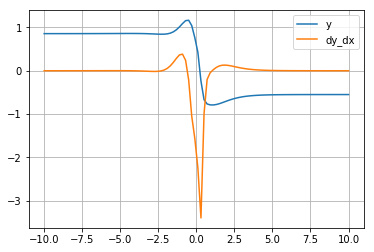

In [42]:
# Let's create an MLP with random weights and compute the gradients wrt the inputs
batch_size = 100
x = np.linspace(-10, 10, batch_size)
mlp_batch = MLPBatch(1, 10, 20, 1)
y = mlp_batch.forward(x.reshape((batch_size, 1))).flatten()

dy_dx = mlp_batch.backward(np.ones((batch_size, 1))).flatten()

fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, dy_dx)
ax.grid(True)
ax.legend(['y', 'dy_dx'])

You can visually inspect whether the computations of the derivative seem correct.

More importantly, we can compute the gradient of a loss wrt the parameters of the MLP. The gradients can be used to update the parameters using gradient descent.

## Training MLP network with backpropagation

Now let us use our code to train an MLP network.

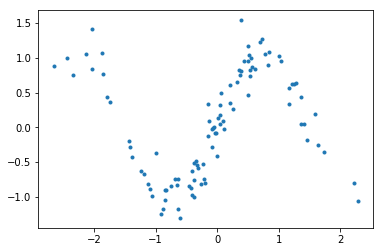

In [43]:
# Let us generate toy data
np.random.seed(2)
x = np.random.randn(100, 1)
x = np.sort(x, axis=0)
targets = np.sin(x * 2 * np.pi / 3)
targets = targets + 0.2 * np.random.randn(*targets.shape)

# Plot the data
fig, ax = plt.subplots(1)
ax.plot(x, targets, '.')

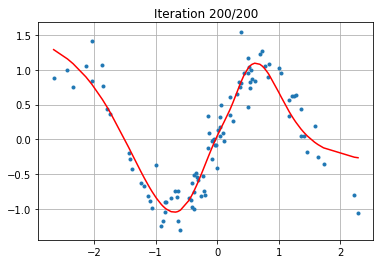

In [44]:
# And train an MLP network using gradient descent
from IPython import display

mlp = MLPBatch(1, 10, 10, 1)  # Create MLP network
loss = MSELoss()  # Create loss

fig, ax = plt.subplots(1)
ax.plot(x, targets, '.')
learning_rate = 0.15
n_epochs = 1 if skip_training else 200
for i in range(n_epochs):
    # Forward computations
    y = mlp.forward(x)
    c = loss.forward(y, targets)
    
    # Backward computations
    dy = loss.backward()
    dx = mlp.backward(dy)

    # Gradient descent update
    learning_rate *= 0.99  # Learning rate annealing
    for module in mlp.__dict__.values():
        if hasattr(module, 'W'):
            module.W = module.W - module.grad_W * learning_rate
            module.b = module.b - module.grad_b * learning_rate

    ax.clear()
    ax.plot(x, targets, '.')
    ax.plot(x, y, 'r-')
    ax.grid(True)
    ax.set_title('Iteration %d/%d' % (i+1, n_epochs))
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.005)
display.clear_output(wait=True)

Now you have implemented backpropagation and trained an MLP network using gradient descent.

PyTorch makes it easier to create neural networks with different architectures and optimize its parameters using (variants of) gradient descent:
* It contains multiple building blocks with forward and backward computations implemented.
* It implements optimization methods that work well for neural networks.
* Computations can be performed either on GPU or CPU using the same code.